In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
style.use('ggplot')

#### Diagnostics for run g.e21.G1850ECOIAF.T62_g16.001 first IAF cycle (62 years)

#### Get the CESM tseries files for nutrients and other vars

In [3]:
case = 'g.e21.G1850ECOIAF.T62_g16.001'

In [4]:
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1'

In [5]:
variables = ['NO3', 'PO4','AOU','O2','SiO3']

In [6]:
coords = {'x':'TLONG','y':'TLAT'}

In [7]:
keepthese = ['z_t','z_t_150m','time_bound','TAREA','REGION_MASK', 'time'] + variables

In [8]:
%%time

ds_list = []

print(f'reading {case}')

ds = xr.Dataset()

for v in variables:
    
    print(v)
    
    #files = sorted(glob(f'{path}/{case}.pop.h.{v}.??????-??????.nc'))       
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.000101-006212.nc'))   #just do the first IAF cycle
    #print(files)
    
    #dsv = xr.open_mfdataset(files, decode_times=True, decode_coords=False)
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e21.G1850ECOIAF.T62_g16.001
NO3
PO4
AOU
O2
SiO3
CPU times: user 2.61 s, sys: 290 ms, total: 2.9 s
Wall time: 4.91 s


#### Just keep the variables we need

In [9]:
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds = ds.drop([v for v in ds.variables if v not in keep_vars])

In [10]:
ds

<xarray.Dataset>
Dimensions:      (d2: 2, nlat: 384, nlon: 320, time: 744, z_t: 60, z_t_150m: 15)
Coordinates:
    TLONG        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT         (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t_150m     (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * z_t          (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * time         (time) object 0001-02-01 00:00:00 ... 0063-01-01 00:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    TAREA        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz           (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    REGION_MASK  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    KMT          (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    NO3          (time, z_t, nlat, nlon) float32 dask.array<chunksize=(744, 60, 384, 3

#### Fix the time dimension so it's the mean of the time bounds

In [11]:
ds["time"] = ds.time_bound.compute().mean(dim="d2")

#### Get the World Ocean Atlas dataset that has been interpolated onto the POP grid

In [12]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA_POPgrid.nc'

In [13]:
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)

#### reset the WOA depth dimension as it's slightly different from CESM one

In [14]:
ds_woa['z_t'] = ds.z_t
tlen=len(ds.time)
tlen

744

#### Make annual mean variables for the last 10 years of the model simulation

In [15]:
ds_annmean = xr.Dataset()
ds_annmean['NO3'] = ds.NO3.isel(time=slice(-120,tlen)).mean(dim='time')
ds_annmean['PO4'] = ds.PO4.isel(time=slice(-120,tlen)).mean(dim='time')
ds_annmean['SiO3'] = ds.SiO3.isel(time=slice(-120,tlen)).mean(dim='time')
ds_annmean['AOU'] = ds.AOU.isel(time=slice(-120,tlen)).mean(dim='time')
ds_annmean['O2'] = ds.O2.isel(time=slice(-120,tlen)).mean(dim='time')

#### Make difference arrays for the nutrients, O$_2$, and AOU

In [16]:
NO3_diff = ds_annmean.NO3 - ds_woa.NO3
PO4_diff = ds_annmean.PO4 - ds_woa.PO4
SiO3_diff = ds_annmean.SiO3 - ds_woa.SiO3
AOU_diff = ds_annmean.AOU - ds_woa.AOU
O2_diff = ds_annmean.O2 - ds_woa.O2

#### Make an annual mean timeseries dataset

In [17]:
ds_annmean_ts = ds.resample({'time':'A'}).mean(dim='time')

#### Set up coordinates for plotting

In [18]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01
years = np.arange(len(ds_annmean_ts.time) + 1)

#### Set up region mask for major basins

In [ ]:
grid_name = 'POP_gx1v7'
ds_regmasks = pop_tools.get_grid(grid_name)

In [ ]:
region_masks = pop_tools.list_region_masks(grid_name)
region_mask='Pacific-Indian-Atlantic'
mask3d = pop_tools.region_mask_3d(grid_name, mask_name=region_mask)

#### -------------------------------------------------------------------------- end of setup

### Surface macronutrient maps

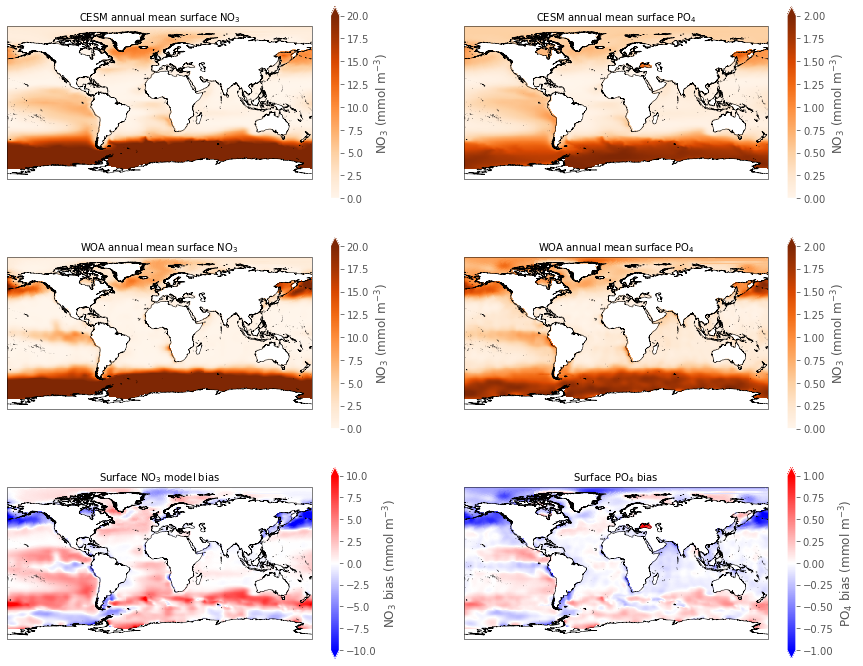

In [47]:
fig = plt.figure(figsize=(15,12))

#COLUMN 1  - NO3

#---- CESM panel
ax = fig.add_subplot(3,2,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface NO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_annmean.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,2,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface NO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,2,5, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface NO$_3$ model bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 NO3_diff.isel(z_t=0), vmin=-10, vmax=10, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='NO$_3$ bias (mmol m$^{-3}$)')

#---- CESM panel
ax = fig.add_subplot(3,2,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface PO$_4$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_annmean.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,2,4, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface PO$_4$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,2,6, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface PO$_4$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 PO4_diff.isel(z_t=0), vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='PO$_4$ bias (mmol m$^{-3}$)')



### Thermocline macronutrient maps (~480m)

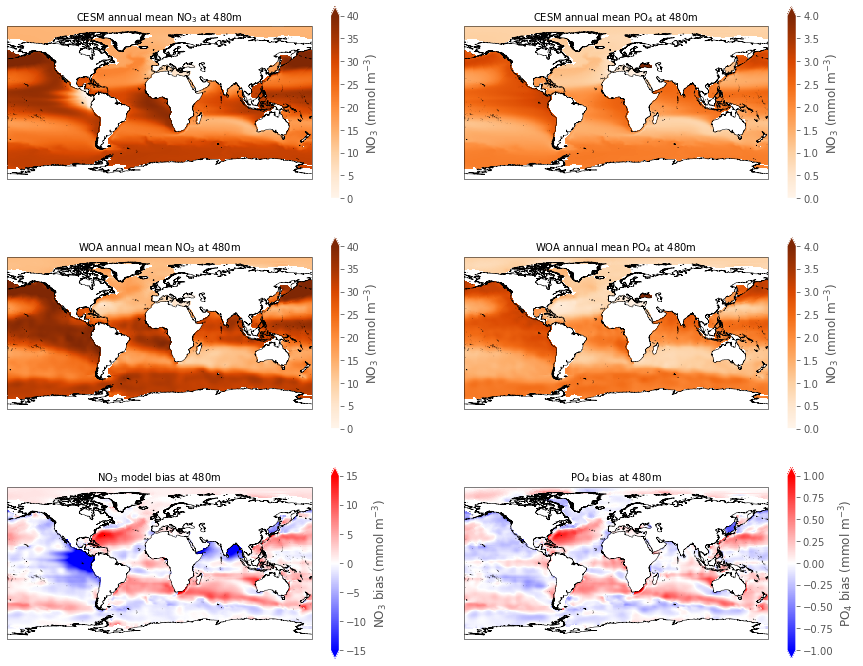

In [19]:
fig = plt.figure(figsize=(15,12))

#COLUMN 1  - NO3

#---- CESM panel
ax = fig.add_subplot(3,2,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean NO$_3$ at 480m', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_annmean.NO3.isel(z_t=32), vmin=0, vmax=40, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,2,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean NO$_3$ at 480m', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.NO3.isel(z_t=32), vmin=0, vmax=40, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,2,5, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('NO$_3$ model bias at 480m', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 NO3_diff.isel(z_t=32), vmin=-15, vmax=15, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='NO$_3$ bias (mmol m$^{-3}$)')

#---- CESM panel
ax = fig.add_subplot(3,2,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean PO$_4$ at 480m', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_annmean.PO4.isel(z_t=32), vmin=0, vmax=4, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,2,4, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean PO$_4$ at 480m', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.PO4.isel(z_t=32), vmin=0, vmax=4, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,2,6, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('PO$_4$ bias  at 480m', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 PO4_diff.isel(z_t=32), vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='PO$_4$ bias (mmol m$^{-3}$)')

### Thermocline O$_2$ and AOU maps

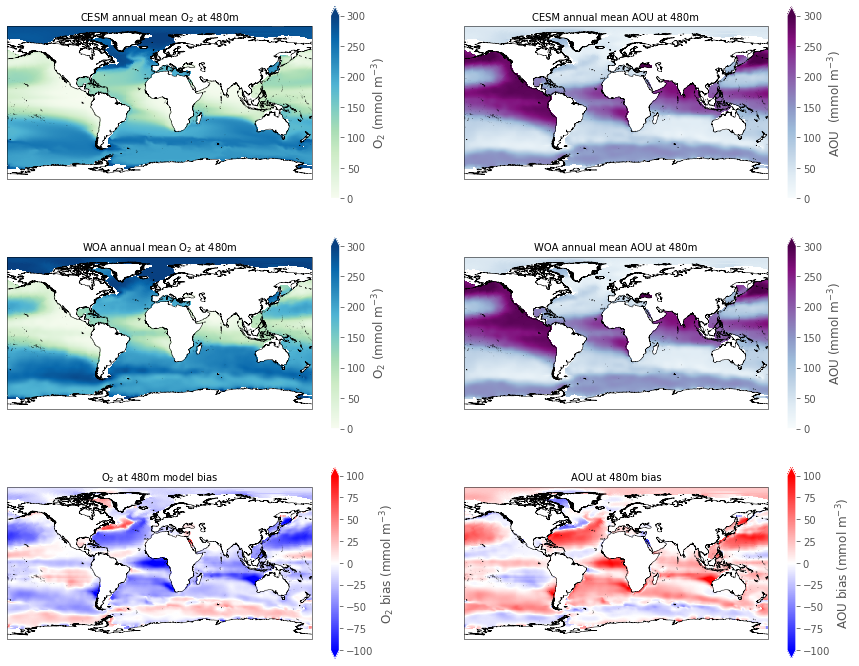

In [43]:
fig = plt.figure(figsize=(15,12))

#COLUMN 1  - O2
#---- CESM panel
ax = fig.add_subplot(3,2,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean O$_2$ at 480m', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_annmean.O2.isel(z_t=32),cmap='GnBu',
                 vmin=0, vmax=300, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='O$_2$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,2,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean O$_2$ at 480m', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.O2.isel(z_t=32), cmap='GnBu',
                 vmin=0, vmax=300, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='O$_2$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,2,5, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('O$_2$ at 480m model bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 O2_diff.isel(z_t=32), cmap='bwr',
                 vmin=-100, vmax=100, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='O$_2$ bias (mmol m$^{-3}$)')

#column 2 AOU
#---- CESM panel
ax = fig.add_subplot(3,2,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean AOU at 480m', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_woa.AOU.isel(z_t=32), cmap='BuPu',
                 vmin=0, vmax=300, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='AOU  (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,2,4, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean AOU at 480m', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.AOU.isel(z_t=32), cmap='BuPu',
                 vmin=0, vmax=300, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='AOU (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,2,6, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('AOU at 480m bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 AOU_diff.isel(z_t=32), cmap='bwr',
                vmin=-100, vmax=100, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='AOU bias (mmol m$^{-3}$)')



#### Global mean nutrient profiles

In [17]:
ds_glb = xr.Dataset({v: ds[v] for v in ['time', 'time_bound']})
ds_glb['NO3']= esmlab.weighted_mean(ds_annmean['NO3'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb['PO4']= esmlab.weighted_mean(ds_annmean['PO4'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb['SiO3']= esmlab.weighted_mean(ds_annmean['SiO3'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb['O2']= esmlab.weighted_mean(ds_annmean['O2'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb['AOU']= esmlab.weighted_mean(ds_annmean['AOU'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

In [18]:
ds_glb_woa = xr.Dataset({v: ds[v] for v in ['time', 'time_bound']})
ds_glb_woa['NO3'] = esmlab.weighted_mean(ds_woa['NO3'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb_woa['PO4'] = esmlab.weighted_mean(ds_woa['PO4'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb_woa['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb_woa['O2'] = esmlab.weighted_mean(ds_woa['O2'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb_woa['AOU'] = esmlab.weighted_mean(ds_woa['AOU'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

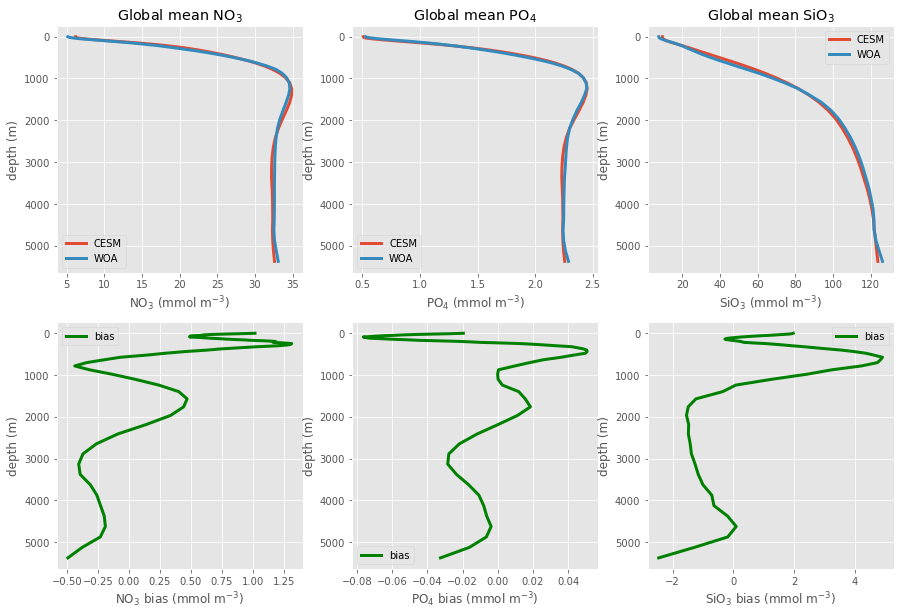

In [19]:
fig = plt.figure(figsize=(15,10))

#COLUMN 1  - NO3

ax = fig.add_subplot(2,3,1)
ax.set_title('Global mean NO$_3$')
ax.plot(ds_glb['NO3'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['NO3'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(2,3,2)
ax.set_title('Global mean PO$_4$')
ax.plot(ds_glb['PO4'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['PO4'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(2,3,3)
ax.set_title('Global mean SiO$_3$')
ax.plot(ds_glb['SiO3'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['SiO3'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 1  - NO3 diff

ax = fig.add_subplot(2,3,4)
ax.plot(ds_glb['NO3'].values - ds_glb_woa['NO3'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4 diff

ax = fig.add_subplot(2,3,5)
ax.plot(ds_glb['PO4'].values - ds_glb_woa['PO4'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3 diff

ax = fig.add_subplot(2,3,6)
ax.plot(ds_glb['SiO3'].values - ds_glb_woa['SiO3'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()



#### Just plotting the upper 500m

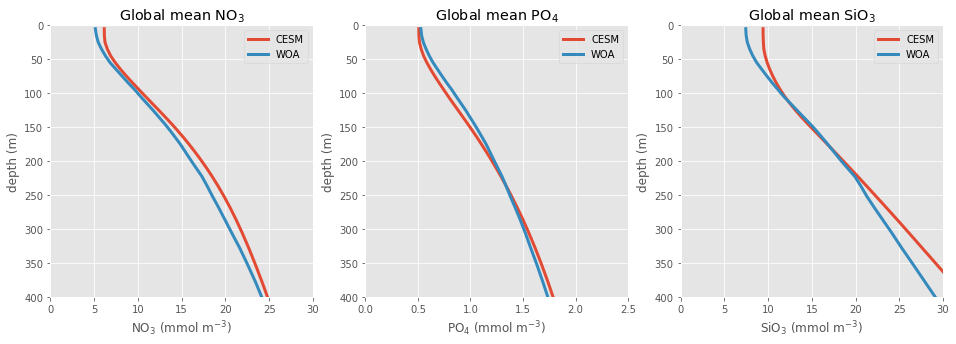

In [20]:
fig = plt.figure(figsize=(16,5))

#COLUMN 1  - NO3

ax = fig.add_subplot(1,3,1)
ax.set_title('Global mean NO$_3$')
ax.plot(ds_glb['NO3'].values, depths, label='CESM',linewidth=3)
ax.plot(ds_glb_woa['NO3'].values, depths, label='WOA',linewidth=3)
ax.legend()
ax.set_ylim(0,400)
ax.set_xlim(0,30)
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(1,3,2)
ax.set_title('Global mean PO$_4$')
ax.plot(ds_glb['PO4'].values, depths, label='CESM',linewidth=3)
ax.plot(ds_glb_woa['PO4'].values, depths, label='WOA',linewidth=3)
ax.legend()
ax.set_ylim(0,400)
ax.set_xlim(0,2.5)
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(1,3,3)
ax.set_title('Global mean SiO$_3$')
ax.plot(ds_glb['SiO3'].values, depths, label='CESM',linewidth=3)
ax.plot(ds_glb_woa['SiO3'].values, depths, label='WOA',linewidth=3)
ax.legend()
ax.set_ylim(0,400)
ax.set_xlim(0,30)
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

### Oxygen profile

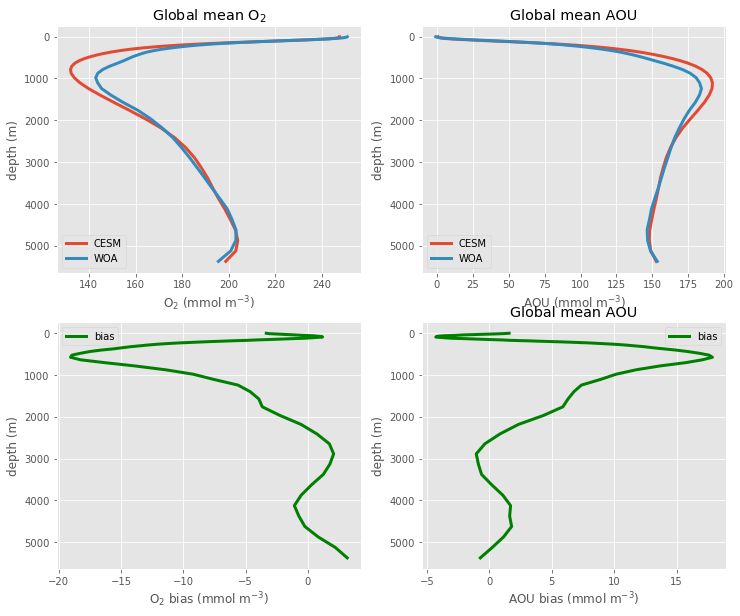

In [23]:
fig = plt.figure(figsize=(12,10))

#COLUMN 1  - O2

ax = fig.add_subplot(2,2,1)
ax.set_title('Global mean O$_2$')
ax.plot(ds_glb['O2'].values, depths, label='CESM',linewidth=3)
ax.plot(ds_glb_woa['O2'].values, depths, label='WOA',linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='O$_2$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 2  - AOU

ax = fig.add_subplot(2,2,2)
ax.set_title('Global mean AOU')
ax.plot(ds_glb['AOU'].values, depths, label='CESM',linewidth=3)
ax.plot(ds_glb_woa['AOU'].values, depths, label='WOA',linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='AOU (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 1  - O2

ax = fig.add_subplot(2,2,3)
ax.plot(ds_glb['O2'].values - ds_glb_woa['O2'].values, depths, label='bias',linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='O$_2$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 2  - AOU

ax = fig.add_subplot(2,2,4)
ax.set_title('Global mean AOU')
ax.plot(ds_glb['AOU'].values - ds_glb_woa['AOU'].values, depths, label='bias',linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='AOU bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

### Regional nutrient profiles

#### Pacific

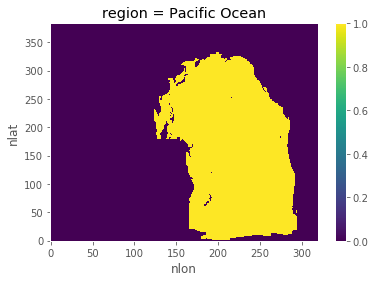

In [26]:
regnum=2
mask3d.isel(region=regnum).plot();

In [27]:
ds_pac = xr.Dataset({v: ds[v] for v in ['time', 'time_bound']})
ds_pac['NO3']= esmlab.weighted_mean(ds_annmean['NO3']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_pac['PO4']= esmlab.weighted_mean(ds_annmean['PO4']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_pac['SiO3']= esmlab.weighted_mean(ds_annmean['SiO3']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_pac['O2']= esmlab.weighted_mean(ds_annmean['O2']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_pac['AOU']= esmlab.weighted_mean(ds_annmean['AOU']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

In [28]:
ds_pac_woa = xr.Dataset({v: ds[v] for v in ['time', 'time_bound']})
ds_pac_woa['NO3'] = esmlab.weighted_mean(ds_woa['NO3']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_pac_woa['PO4'] = esmlab.weighted_mean(ds_woa['PO4']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_pac_woa['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_pac_woa['O2'] = esmlab.weighted_mean(ds_woa['O2']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_pac_woa['AOU'] = esmlab.weighted_mean(ds_woa['AOU']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

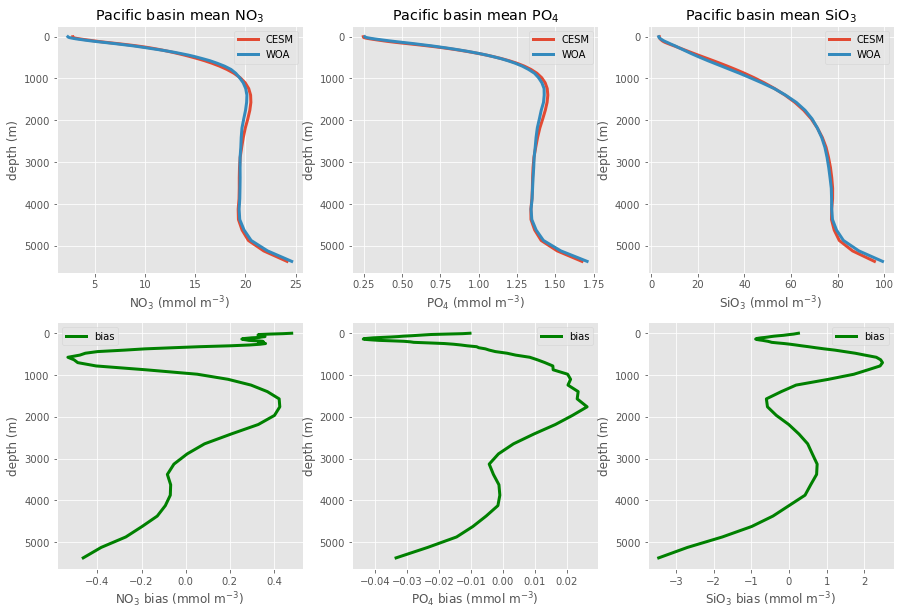

In [30]:
fig = plt.figure(figsize=(15,10))

#COLUMN 1  - NO3

ax = fig.add_subplot(2,3,1)
ax.set_title('Pacific basin mean NO$_3$')
ax.plot(ds_pac['NO3'].values, depths, label='CESM',linewidth=3)
ax.plot(ds_pac_woa['NO3'].values, depths, label='WOA',linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(2,3,2)
ax.set_title('Pacific basin mean PO$_4$')
ax.plot(ds_pac['PO4'].values, depths, label='CESM',linewidth=3)
ax.plot(ds_pac_woa['PO4'].values, depths, label='WOA',linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(2,3,3)
ax.set_title('Pacific basin mean SiO$_3$')
ax.plot(ds_pac['SiO3'].values, depths, label='CESM',linewidth=3)
ax.plot(ds_pac_woa['SiO3'].values, depths, label='WOA',linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 1  - NO3 diff

ax = fig.add_subplot(2,3,4)
ax.plot(ds_pac['NO3'].values - ds_pac_woa['NO3'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4 diff

ax = fig.add_subplot(2,3,5)
ax.plot(ds_pac['PO4'].values - ds_pac_woa['PO4'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3 diff

ax = fig.add_subplot(2,3,6)
ax.plot(ds_pac['SiO3'].values - ds_pac_woa['SiO3'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

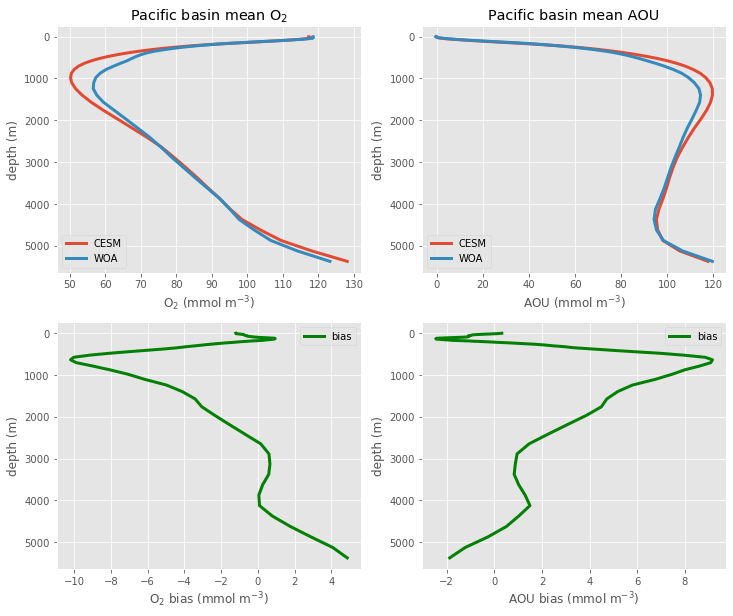

In [32]:
fig = plt.figure(figsize=(12,10))

#COLUMN 1  - O2

ax = fig.add_subplot(2,2,1)
ax.set_title('Pacific basin mean O$_2$')
ax.plot(ds_pac['O2'].values, depths, label='CESM',linewidth=3)
ax.plot(ds_pac_woa['O2'].values, depths, label='WOA',linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='O$_2$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - AOU

ax = fig.add_subplot(2,2,2)
ax.set_title('Pacific basin mean AOU')
ax.plot(ds_pac['AOU'].values, depths, label='CESM',linewidth=3)
ax.plot(ds_pac_woa['AOU'].values, depths, label='WOA',linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='AOU (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 1  - O2 bias

ax = fig.add_subplot(2,2,3)
ax.plot(ds_pac['O2'].values - ds_pac_woa['O2'].values, depths, label='bias',linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='O$_2$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - AOU bias

ax = fig.add_subplot(2,2,4)
ax.plot(ds_pac['AOU'].values - ds_pac_woa['AOU'].values, depths, label='bias',linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='AOU bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#### Atlantic

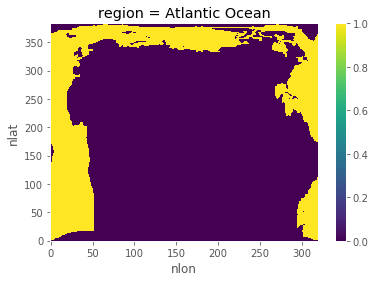

In [33]:
regnum=1
mask3d.isel(region=regnum).plot();

In [34]:
ds_atl = xr.Dataset({v: ds[v] for v in ['time', 'time_bound']})
ds_atl['NO3']= esmlab.weighted_mean(ds_annmean['NO3']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl['PO4']= esmlab.weighted_mean(ds_annmean['PO4']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl['SiO3']= esmlab.weighted_mean(ds_annmean['SiO3']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl['O2']= esmlab.weighted_mean(ds_annmean['O2']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl['AOU']= esmlab.weighted_mean(ds_annmean['AOU']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

In [35]:
ds_atl_woa = xr.Dataset({v: ds[v] for v in ['time', 'time_bound']})
ds_atl_woa['NO3'] = esmlab.weighted_mean(ds_woa['NO3']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl_woa['PO4'] = esmlab.weighted_mean(ds_woa['PO4']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl_woa['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl_woa['O2'] = esmlab.weighted_mean(ds_woa['O2']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl_woa['AOU'] = esmlab.weighted_mean(ds_woa['AOU']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

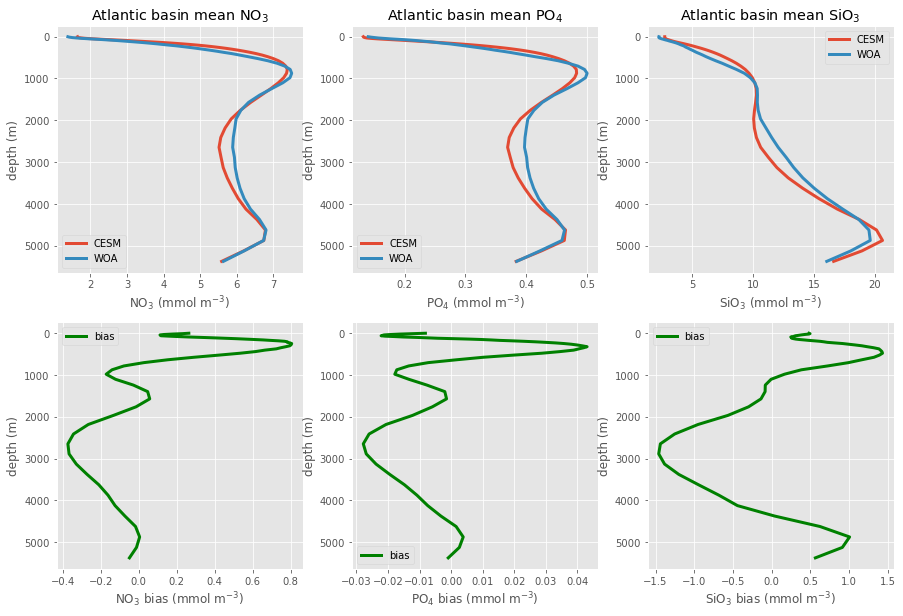

In [37]:
fig = plt.figure(figsize=(15,10))

#COLUMN 1  - NO3
ax = fig.add_subplot(2,3,1)
ax.set_title('Atlantic basin mean NO$_3$')
ax.plot(ds_atl['NO3'].values, depths, label='CESM',linewidth=3)
ax.plot(ds_atl_woa['NO3'].values, depths, label='WOA',linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4
ax = fig.add_subplot(2,3,2)
ax.set_title('Atlantic basin mean PO$_4$')
ax.plot(ds_atl['PO4'].values, depths, label='CESM',linewidth=3)
ax.plot(ds_atl_woa['PO4'].values, depths, label='WOA',linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3
ax = fig.add_subplot(2,3,3)
ax.set_title('Atlantic basin mean SiO$_3$')
ax.plot(ds_atl['SiO3'].values, depths, label='CESM',linewidth=3)
ax.plot(ds_atl_woa['SiO3'].values, depths, label='WOA',linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 1  - NO3 bias
ax = fig.add_subplot(2,3,4)
ax.plot(ds_atl['NO3'].values - ds_atl_woa['NO3'].values, depths, label='bias',linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4 bias
ax = fig.add_subplot(2,3,5)
ax.plot(ds_atl['PO4'].values - ds_atl_woa['PO4'].values, depths, label='bias',linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3 bias
ax = fig.add_subplot(2,3,6)
ax.plot(ds_atl['SiO3'].values - ds_atl_woa['SiO3'].values, depths, label='bias',linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

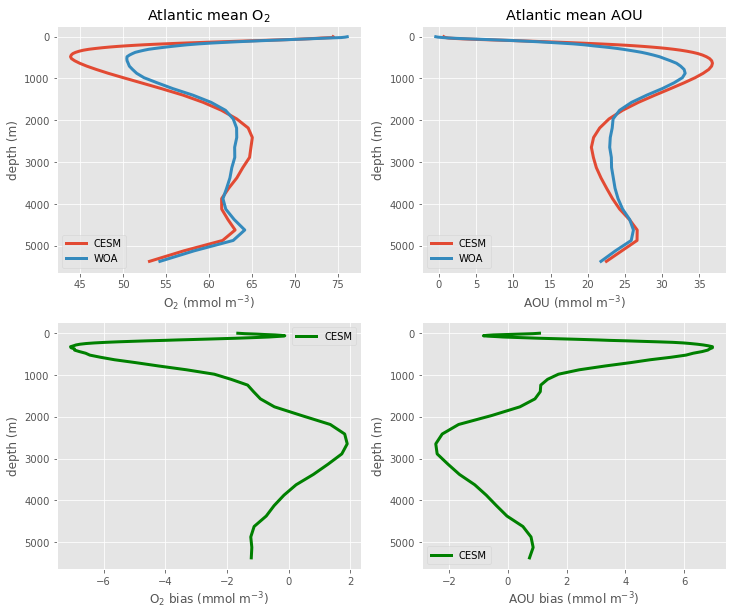

In [39]:
fig = plt.figure(figsize=(12,10))

#COLUMN 1  - O2
ax = fig.add_subplot(2,2,1)
ax.set_title('Atlantic mean O$_2$')
ax.plot(ds_atl['O2'].values, depths, label='CESM',linewidth=3)
ax.plot(ds_atl_woa['O2'].values, depths, label='WOA',linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='O$_2$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 1  - AOU
ax = fig.add_subplot(2,2,2)
ax.set_title('Atlantic mean AOU')
ax.plot(ds_atl['AOU'].values, depths, label='CESM',linewidth=3)
ax.plot(ds_atl_woa['AOU'].values, depths, label='WOA',linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='AOU (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 1  - O2 bias
ax = fig.add_subplot(2,2,3)
ax.plot(ds_atl['O2'].values - ds_atl_woa['O2'].values, depths, label='CESM',linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='O$_2$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 1  - AOU bias
ax = fig.add_subplot(2,2,4)
ax.plot(ds_atl['AOU'].values - ds_atl_woa['AOU'].values, depths, label='CESM',linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='AOU bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

### Look at drift in nutrients and O$_2$ at 500m

In [20]:
ds_annmean_ts

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, time: 62, z_t: 60, z_t_150m: 15)
Coordinates:
  * time         (time) object 0001-12-31 00:00:00 ... 0062-12-31 00:00:00
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... nan nan nan
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... nan nan nan
  * z_t_150m     (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * z_t          (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    TAREA        (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    dz           (time, z_t) float32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    REGION_MASK  (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    KMT          (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    NO3          (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 60, 384, 320

#### Global

In [21]:
%%time
ts_glob_500m = xr.Dataset({v: ds_annmean_ts[v] for v in ['time']})
ts_glob_500m['O2'] = esmlab.weighted_mean(ds_annmean_ts['O2'].isel(z_t=32), weights=area, dim=['nlat', 'nlon']).compute()
ts_glob_500m['PO4'] = esmlab.weighted_mean(ds_annmean_ts['PO4'].isel(z_t=32), weights=area, dim=['nlat', 'nlon']).compute()
ts_glob_500m['NO3'] = esmlab.weighted_mean(ds_annmean_ts['NO3'].isel(z_t=32), weights=area, dim=['nlat', 'nlon']).compute()
ts_glob_500m['SiO3'] = esmlab.weighted_mean(ds_annmean_ts['SiO3'].isel(z_t=32), weights=area, dim=['nlat', 'nlon']).compute()

CPU times: user 14min 36s, sys: 8min 53s, total: 23min 30s
Wall time: 10min 36s


#### Atlantic

In [22]:
ts_Atl = xr.Dataset({v: ds_annmean_first62yrs[v] for v in ['time']})
regnum=1
ts_Atl['O2'] = esmlab.weighted_mean(ds_annmean_ts['O2'].isel(z_t=32)*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Atl['PO4'] = esmlab.weighted_mean(ds_annmean_ts['PO4'].isel(z_t=32)*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Atl['NO3'] = esmlab.weighted_mean(ds_annmean_ts['NO3'].isel(z_t=32)*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Atl['SiO3'] = esmlab.weighted_mean(ds_annmean_ts['SiO3'].isel(z_t=32)*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()

NameError: name 'ds_annmean_first62yrs' is not defined

#### Pacific

In [ ]:
ts_Pac = xr.Dataset({v: ds_annmean_first62yrs[v] for v in ['time']})
regnum=2
ts_Pac['O2'] = esmlab.weighted_mean(ds_annmean_ts['O2'].isel(z_t=32)*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Pac['PO4'] = esmlab.weighted_mean(ds_annmean_ts['PO4'].isel(z_t=32)*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Pac['NO3'] = esmlab.weighted_mean(ds_annmean_ts['NO3'].isel(z_t=32)*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Pac['SiO3'] = esmlab.weighted_mean(ds_annmean_ts['SiO3'].isel(z_t=32)*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()

#### Indian

In [ ]:
ts_Ind = xr.Dataset({v: ds_annmean_first62yrs[v] for v in ['time']})
regnum=3
ts_Ind['O2'] = esmlab.weighted_mean(ds_annmean_ts['O2'].isel(z_t=32)*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Ind['PO4'] = esmlab.weighted_mean(ds_annmean_ts['PO4'].isel(z_t=32)*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Ind['NO3'] = esmlab.weighted_mean(ds_annmean_ts['NO3'].isel(z_t=32)*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Ind['SiO3'] = esmlab.weighted_mean(ds_annmean_ts['SiO3'].isel(z_t=32)*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()

### Plot O$_2$ timeseries for each basin

In [ ]:
fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1,3,1)
ax.set_title('O$_2$ at 480m in the Atlantic')
ax.scatter(years,ts_Atl['O2'],color='blue')
ax.set(ylabel='O$_2$ (mmol m$^{-3}$)',xlabel='year of simulation')

ax = fig.add_subplot(1,3,2)
ax.set_title('O$_2$ at 480m in the Indian')
ax.scatter(years,ts_Ind['O2'],color='blue')
ax.set(ylabel='O$_2$ (mmol m$^{-3}$)',xlabel='year of simulation')

ax = fig.add_subplot(1,3,3)
ax.set_title('O$_2$ at 480m in the Pacific')
ax.scatter(years,ts_Pac['O2'],color='blue')
ax.set(ylabel='O$_2$ (mmol m$^{-3}$)',xlabel='year of simulation');

### Plot global O$_2$ timeseries

In [ ]:
fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('Global O$_2$ at 480m')
ax.scatter(years,ts_glob_500m['O2'],color='blue')
ax.set(ylabel='O$_2$ (mmol m$^{-3}$)',xlabel='year of simulation')

### Plot PO$_4$ timeseries for basins

In [ ]:
fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1,3,1)
ax.set_title('PO$_4$ in the Atlantic')
ax.scatter(years,ts_Atl['PO4'],color='blue')
ax.set(ylabel='PO$_4$ (mmol m$^{-3}$)',xlabel='year of simulation')

ax = fig.add_subplot(1,3,2)
ax.set_title('PO$_4$ in the Indian')
ax.scatter(years,ts_Ind['PO4'],color='blue')
ax.set(ylabel='PO$_4$ (mmol m$^{-3}$)',xlabel='year of simulation')

ax = fig.add_subplot(1,3,3)
ax.set_title('PO$_4$ in the Pacific')
ax.scatter(years,ts_Pac['PO4'],color='blue')
ax.set(ylabel='PO$_4$ (mmol m$^{-3}$)',xlabel='year of simulation');

### Plot global PO$_4$ timeseries

In [ ]:
fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('Global PO$_4$ at 480m')
ax.scatter(years,ts_glob_500m['PO4'],color='blue')
ax.set(ylabel='PO$_4$ (mmol m$^{-3}$)',xlabel='year of simulation')

### Plot NO$_3$ timeseries for basins

In [ ]:
fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1,3,1)
ax.set_title('NO$_3$ in the Atlantic')
ax.scatter(years,ts_Atl['NO3'],color='blue')
ax.set(ylabel='NO$_3$ (mmol m$^{-3}$)',xlabel='year of simulation')

ax = fig.add_subplot(1,3,2)
ax.set_title('NO$_3$ in the Indian')
ax.scatter(years,ts_Ind['NO3'],color='blue')
ax.set(ylabel='NO$_3$ (mmol m$^{-3}$)',xlabel='year of simulation')

ax = fig.add_subplot(1,3,3)
ax.set_title('NO$_3$ in the Pacific')
ax.scatter(years,ts_Pac['NO3'],color='blue')
ax.set(ylabel='NO$_3$ (mmol m$^{-3}$)',xlabel='year of simulation');

### Plot global NO$_3$ timeseries

In [ ]:
fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('Global NO$_3$ at 480m')
ax.scatter(years,ts_glob_500m['NO3'],color='blue')
ax.set(ylabel='NO$_3$ (mmol m$^{-3}$)',xlabel='year of simulation')

### Plot the SiO3 timeseries for each basin

In [ ]:
fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1,3,1)
ax.set_title('SiO$_3$ in the Atlantic')
ax.scatter(years,ts_Atl['SiO3'],color='blue')
ax.set(ylabel='SiO$_3$ (mmol m$^{-3}$)',xlabel='year of simulation')

ax = fig.add_subplot(1,3,2)
ax.set_title('SiO$_3$ in the Indian')
ax.scatter(years,ts_Ind['SiO3'],color='blue')
ax.set(ylabel='SiO$_3$ (mmol m$^{-3}$)',xlabel='year of simulation')

ax = fig.add_subplot(1,3,3)
ax.set_title('SiO$_3$ in the Pacific')
ax.scatter(years,ts_Pac['SiO3'],color='blue')
ax.set(ylabel='SiO$_3$ (mmol m$^{-3}$)',xlabel='year of simulation');

### Plot the global SiO$_3$ timeseries

In [ ]:
fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('Global SiO$_3$ at 480m')
ax.scatter(years,ts_glob_500m['SiO3'],color='blue')
ax.set(ylabel='SiO$_3$ (mmol m$^{-3}$)',xlabel='year of simulation')

## Try making Hovmoller diagrams of nutient/O2 biases (time verus depth)

#### WOA for making biases

In [34]:
woa_Pac = xr.Dataset({v: ds_woa[v] for v in ['z_t']})
regnum=2
woa_Pac['O2'] = esmlab.weighted_mean(ds_woa['O2']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
woa_Pac['NO3'] = esmlab.weighted_mean(ds_woa['NO3']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
woa_Pac['PO4'] = esmlab.weighted_mean(ds_woa['PO4']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
woa_Pac['AOU'] = esmlab.weighted_mean(ds_woa['AOU']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()

In [35]:
woa_Atl = xr.Dataset({v: ds_woa[v] for v in ['z_t']})
regnum=1
woa_Atl['O2'] = esmlab.weighted_mean(ds_woa['O2']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
woa_Atl['NO3'] = esmlab.weighted_mean(ds_woa['NO3']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
woa_Atl['PO4'] = esmlab.weighted_mean(ds_woa['PO4']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
woa_Atl['AOU'] = esmlab.weighted_mean(ds_woa['AOU']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()

In [36]:
woa_global = xr.Dataset({v: ds_woa[v] for v in ['z_t']})
woa_global['O2'] = esmlab.weighted_mean(ds_woa['O2'], weights=area, dim=['nlat', 'nlon']).compute()
woa_global['NO3'] = esmlab.weighted_mean(ds_woa['NO3'], weights=area, dim=['nlat', 'nlon']).compute()
woa_global['PO4'] = esmlab.weighted_mean(ds_woa['PO4'], weights=area, dim=['nlat', 'nlon']).compute()
woa_global['AOU'] = esmlab.weighted_mean(ds_woa['AOU'], weights=area, dim=['nlat', 'nlon']).compute()

#### CESM timeseries: Pacific, Alantic, global

Pacific

In [ ]:
%%time
regnum=2
ts_Pac = xr.Dataset({v: ds_annmean_ts[v] for v in ['time','z_t']})
ts_Pac['O2'] = esmlab.weighted_mean(ds_annmean_ts['O2']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Pac['PO4'] = esmlab.weighted_mean(ds_annmean_ts['PO4']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Pac['NO3'] = esmlab.weighted_mean(ds_annmean_ts['NO3']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Pac['AOU'] = esmlab.weighted_mean(ds_annmean_ts['AOU']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()

In [ ]:
diff_Pac = ts_Pac - woa_Pac
diff_Pac=diff_Pac.transpose()
diff_Pac_top=diff_Pac.isel(z_t=slice(0,40))
diff_Pac_bottom=diff_Pac.isel(z_t=slice(40,60))

Atlantic

In [ ]:
%%time
regnum=1
ts_Atl = xr.Dataset({v: ds_annmean_ts[v] for v in ['time','z_t']})
ts_Atl['O2'] = esmlab.weighted_mean(ds_annmean_ts['O2']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Atl['PO4'] = esmlab.weighted_mean(ds_annmean_ts['PO4']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Atl['NO3'] = esmlab.weighted_mean(ds_annmean_ts['NO3']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Atl['AOU'] = esmlab.weighted_mean(ds_annmean_ts['AOU']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()

In [ ]:
diff_Atl = ts_Atl - woa_Atl
diff_Atl=diff_Atl.transpose()
diff_Atl_top=diff_Atl.isel(z_t=slice(0,40))
diff_Atl_bottom=diff_Atl.isel(z_t=slice(40,60))

Global

In [ ]:
%%time
ts_global = xr.Dataset({v: ds_annmean_ts[v] for v in ['time','z_t']})
ts_global['O2'] = esmlab.weighted_mean(ds_annmean_ts['O2'], weights=area, dim=['nlat', 'nlon']).compute()
ts_global['PO4'] = esmlab.weighted_mean(ds_annmean_ts['PO4'], weights=area, dim=['nlat', 'nlon']).compute()
ts_global['NO3'] = esmlab.weighted_mean(ds_annmean_ts['NO3'], weights=area, dim=['nlat', 'nlon']).compute()
ts_global['AOU'] = esmlab.weighted_mean(ds_annmean_ts['AOU'], weights=area, dim=['nlat', 'nlon']).compute()

In [ ]:
diff_global = ts_global - woa_global
diff_global=diff_global.transpose()
diff_global_top=diff_global.isel(z_t=slice(0,40))
diff_global_bottom=diff_global.isel(z_t=slice(40,60))

#### Set up dims for plotting

In [ ]:
z_top=depths.isel(z_t=slice(0,40))
z_bottom=depths.isel(z_t=slice(40,60))
years = np.arange(62) + 1

## O$_2$

#### Plot Pacific O$_2$

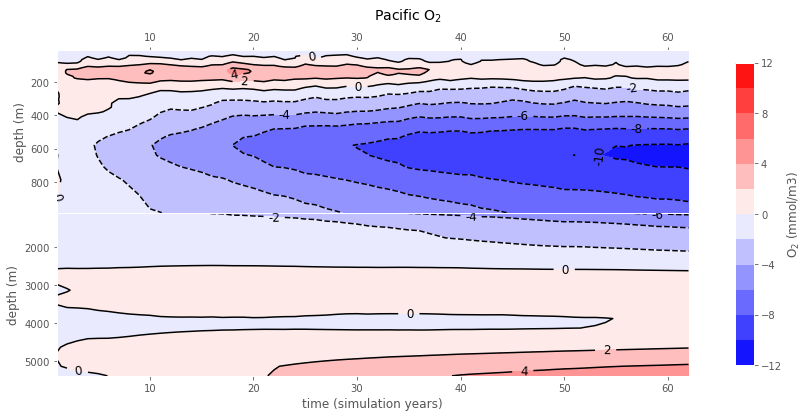

In [54]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Pacific O$_2$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12]
pc=ax.contourf(years, z_top, diff_Pac_top['O2'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_Pac_top['O2'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Pac_bottom['O2'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_Pac_bottom['O2'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='O$_2$ (mmol/m3)')

In [43]:
# #this cell plots normal depth versus time plot for Pacific O2
# fig = plt.figure(figsize=(15,7))
# plt.suptitle('Pacific', fontsize=12)
# ax = fig.add_subplot(1,1,1)
# ax.set_title('AOU', fontsize=10)
# levels = [-10, -8,-6,-4, -2, 0, 2, 4,6,8,10]
# pc=ax.contourf(years, depths, diff_Pac['O2'], levels, cmap='bwr')
# contour = plt.contour(years, depths, diff_Pac['O2'], levels, colors='k')
# plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
# cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='AOU (mmol/m3)')
# ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
# ax.invert_yaxis()

#### Plot Atlantic O2

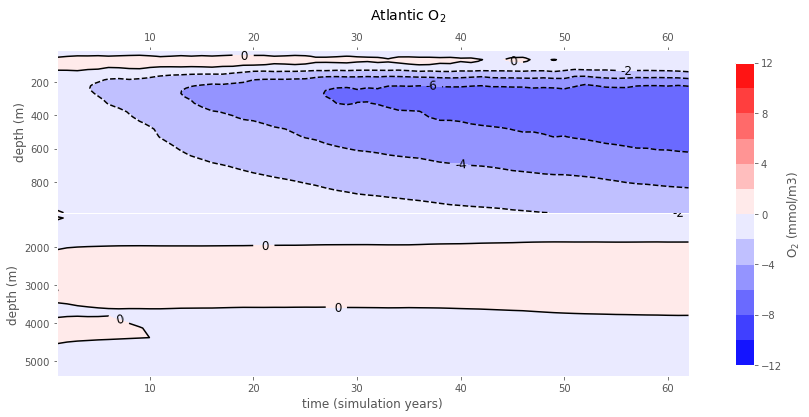

In [55]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Atlantic O$_2$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12]
pc=ax.contourf(years, z_top, diff_Atl_top['O2'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_Atl_top['O2'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Atl_bottom['O2'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_Atl_bottom['O2'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='O$_2$ (mmol/m3)')

#### Plot Global O2

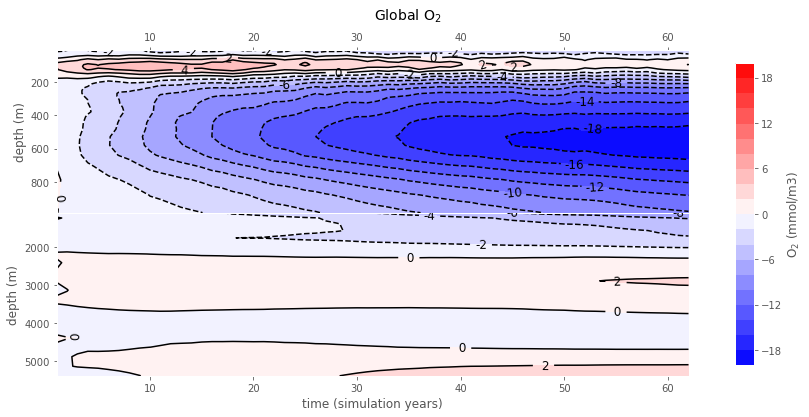

In [57]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Global O$_2$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18,20]
pc=ax.contourf(years, z_top, diff_global_top['O2'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_global_top['O2'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_global_bottom['O2'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_global_bottom['O2'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='O$_2$ (mmol/m3)')

## NO$_3$

#### Plot Pacific NO$_3$

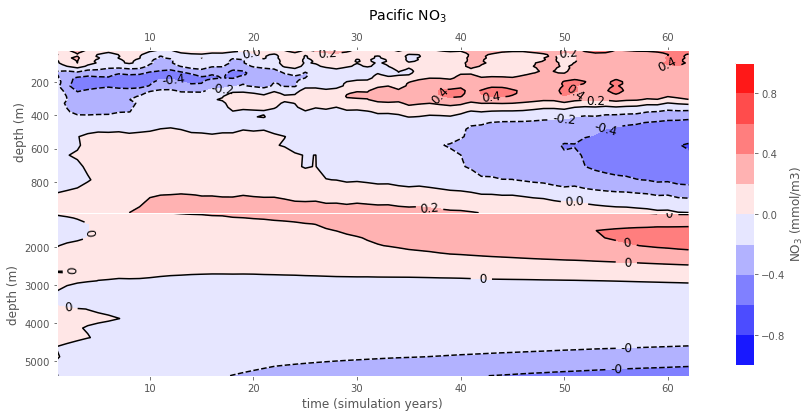

In [58]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Pacific NO$_3$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1]
pc=ax.contourf(years, z_top, diff_Pac_top['NO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_Pac_top['NO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Pac_bottom['NO3'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_Pac_bottom['NO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='NO$_3$ (mmol/m3)')

#### Plot Atlantic NO$_3$

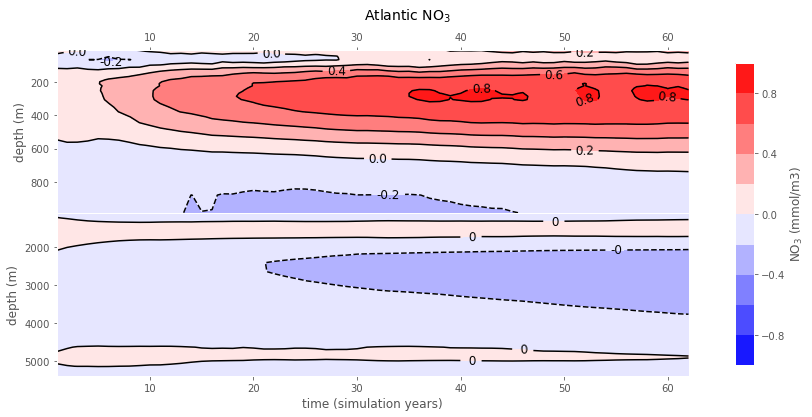

In [59]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Atlantic NO$_3$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1]
pc=ax.contourf(years, z_top, diff_Atl_top['NO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_Atl_top['NO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Atl_bottom['NO3'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_Atl_bottom['NO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='NO$_3$ (mmol/m3)')

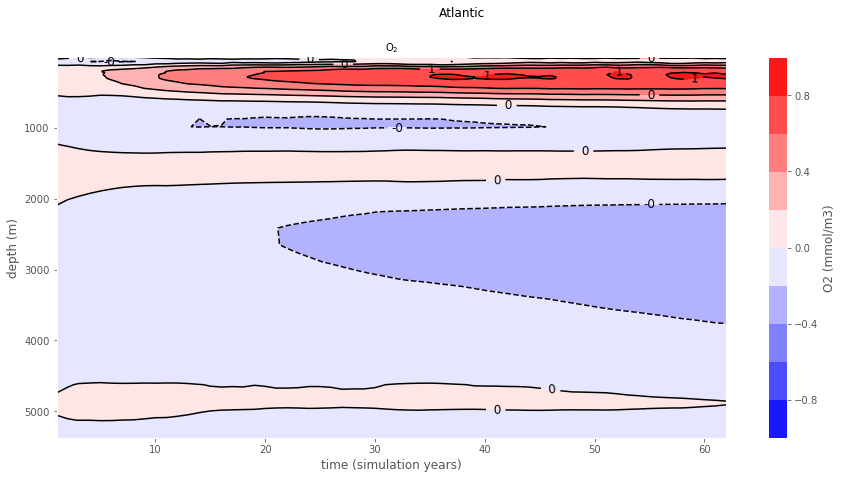

In [60]:
#this cell plots normal depth versus time plot for Atlantic NO3 cause the above one looks a bit weird between upper and lower panel
fig = plt.figure(figsize=(15,7))
plt.suptitle('Atlantic', fontsize=12)
ax = fig.add_subplot(1,1,1)
ax.set_title('O$_2$', fontsize=10)
levels = [-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1]
pc=ax.contourf(years, depths, diff_Atl['NO3'], levels, cmap='bwr')
contour = plt.contour(years, depths, diff_Atl['NO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='O2 (mmol/m3)')
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

#### Global NO$_3$

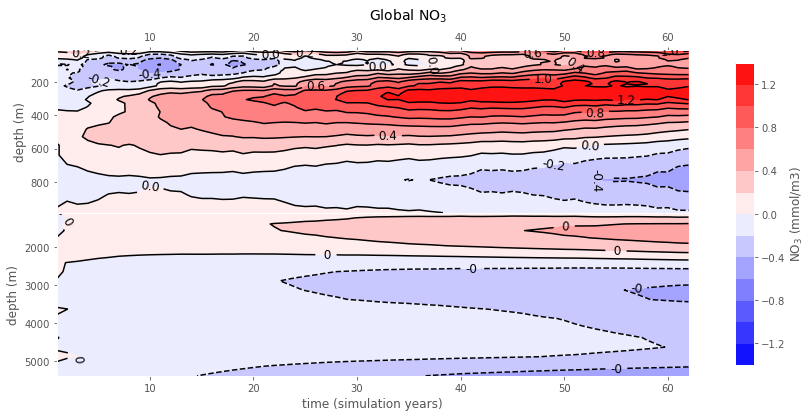

In [61]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Global NO$_3$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-1.4,-1.2,-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1,1.2,1.4]
pc=ax.contourf(years, z_top, diff_global_top['NO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_global_top['NO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_global_bottom['NO3'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_global_bottom['NO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='NO$_3$ (mmol/m3)')

## SiO$_3$

#### Atlantic SiO$_3$

In [ ]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Atlantic SiO$_3$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1]
pc=ax.contourf(years, z_top, diff_Atl_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_Atl_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Atl_bottom['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_Atl_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ (mmol/m3)')

#### Pacific SiO$_3$

In [ ]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Pacific SiO$_3$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1]
pc=ax.contourf(years, z_top, diff_Pac_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_Pac_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Pac_bottom['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_Pac_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ (mmol/m3)')

#### Global SiO$_3$

In [ ]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Global SiO$_3$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-1.4,-1.2,-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1,1.2,1.4]
pc=ax.contourf(years, z_top, diff_global_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_global_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_global_bottom['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_global_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ (mmol/m3)')